# Final game board analysis

In [1]:


tickets_df = pd.read_csv('tickets_latlong.csv')
tickets_df = tickets_df.drop(['city_a', 'city_b', 'points', 'long_regular', 'category'], 1)

connections_df = pd.read_csv('routes.csv')
connections_df.columns = connections_df.columns.str.lower().str.replace(" ", '_')
connections_df = connections_df.drop(['city_a', 'city_b', 'tunnel', 'ferry', 'ferry_count'], 1)


NameError: name 'pd' is not defined

In [7]:
# setup modules
import os
import pandas as pd
import json
from collections import defaultdict
from pprint import pprint
import sys
import heapq
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


## Loading in our data

In [8]:
# loading in our data 

cities_df = pd.read_csv('cities_xy.csv', index_col=[2])
cities = cities_df['city_formatted']
n_cities = len(cities)

connections_df = pd.read_csv('routes.csv')
connections_df.columns = connections_df.columns.str.lower().str.replace(" ", '_')
connections_df = connections_df.drop(['city_a', 'city_b', 'tunnel', 'ferry', 'ferry_count', 'lat_city_a', 'long_city_a','lat_city_b','long_city_b'], 1)
n_connections = len(connections_df.index)


connections = defaultdict(list)
# keys = cityA, values = (city_2)
for ind, city_A, city_B, dist, col in connections_df.itertuples():
    connections[city_A].append((city_B, dist))
    connections[city_B].append((city_A, dist))

/var/folders/qx/nkh2pq6x3_193757ddxvrcf40000gp/T/ipykernel_16914/3441782238.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  connections_df = connections_df.drop(['city_a', 'city_b', 'tunnel', 'ferry', 'ferry_count', 'lat_city_a', 'long_city_a','lat_city_b','long_city_b'], 1)


## Shortest distance
The below shows Dijkstra's algorithm in practice. Credit goes to [Rob Bettles]("https://github.com/Rob217/TicketToRideAnalysis"). 

In [9]:
distances = dict()

for start in cities:
    distances[start] = dict()
    for city in cities:
        if city == start:
            distances[start][city] = 0
        else:
            distances[start][city] = sys.maxsize

    curr_city = start
    unvisited = distances[start].copy()

    while True:
        del unvisited[curr_city]

        for next_city, distance in connections[curr_city]:
            if next_city in unvisited:
                distances[start][next_city] = min(
                    distances[start][next_city],
                    distances[start][curr_city] + distance)
                unvisited[next_city] = distances[start][next_city]

        if len(unvisited) == 0:
            break

        curr_city = min(unvisited, key=unvisited.get)

### Cleaning up one of our dataframes

In [11]:
cities_df
cities_df = cities_df.set_index('city_formatted')

In [12]:
cities_df = cities_df.drop('city', 1)

/var/folders/qx/nkh2pq6x3_193757ddxvrcf40000gp/T/ipykernel_16914/1664289839.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  cities_df = cities_df.drop('city', 1)


## Finding the 'n' shortest routes to fulfill each ticket
Every ticket has multiple ways for a player to fullfil it and collect the points associated with the ticket card. "n" represents the number of possible routes we will use to inspect the liklihood of a route being taken. In other words, if n=5, that means the heat map will treat the five shortest routes to fulfill each ticket with equal measure. 

In [14]:
tickets_df = pd.read_csv('tickets_latlong.csv')
tickets_df = tickets_df.drop(['city_a', 'city_b', 'points', 'long_regular', 'category'], 1)

n_visited = [0 for _ in range(n_connections)]

for i_ticket, start, end, lat_a, long_a, lat_b, long_b in tickets_df.itertuples():
    costs = defaultdict(set)
    for i_conn, city_A, city_B, dist, col in connections_df.itertuples():
        cost = min(distances[start][city_A] + distances[end][city_B],
                   distances[start][city_B] + distances[end][city_A]) + dist
        costs[cost].add(i_conn)
    
    n_include = 5
    cost_vals = heapq.nsmallest(n_include, costs.keys())
    
    for cost in cost_vals:
        for i_conn in costs[cost]:
            n_visited[i_conn] += 1
    
connections_li = connections_df.values.tolist()
sorted_connections = [connections_li[i] for i in np.argsort(n_visited)]
#print(sorted_connections)

/var/folders/qx/nkh2pq6x3_193757ddxvrcf40000gp/T/ipykernel_16914/500386719.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  tickets_df = tickets_df.drop(['city_a', 'city_b', 'points', 'long_regular', 'category'], 1)


In [ ]:
## Plotting the number of tickets going through a single route 

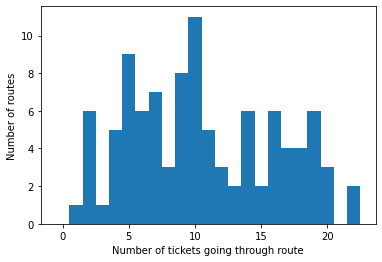

In [15]:
fig, ax = plt.subplots()
mpl.rcParams['figure.dpi'] = 100

ax.hist(n_visited, np.arange(-0.5, max(n_visited) + 0.5))
ax.set_xlabel('Number of tickets going through route')
ax.set_ylabel('Number of routes')

plt.show()

In [401]:
cities_df.dtypes

x_coord    int64
y_coord    int64
dtype: object

In [402]:
#plt.plot([x1*w, x2*w], [h - y1*h, h - y2*h]
type(y1)
cities_df['y_coord'] = cities_df['y_coord'].astype(int)


In [27]:
# cities_df['x_coord'] = cities_df['x_coord'].str.replace(',', '')
# cities_df['x_coord'] = cities_df['x_coord'].astype(int)


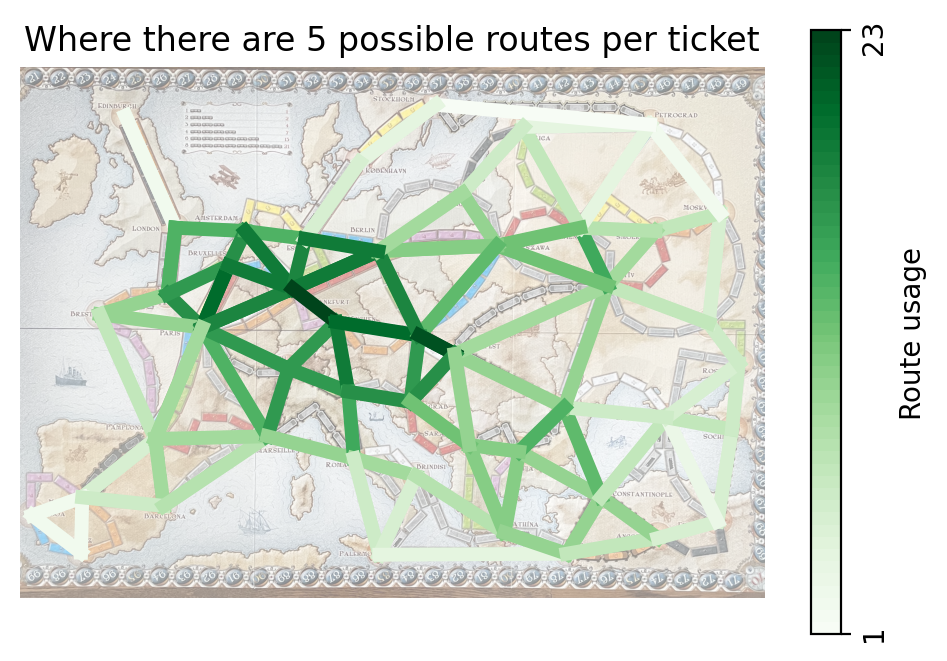

In [26]:
fig, ax = plt.subplots()
mpl.rcParams['figure.dpi'] = 200

# print map image
img = plt.imread(os.path.join('..', 'ticket_to_ride_images', 'europe_board.png'))
#file:///Users/jessieblaeser/Documents/datastudio_spring2022/homework/assignment1/ticket_to_ride_images/europe_board.png
plt.imshow(img, alpha=0.5)
h, w, z = np.shape(img)
plt.axis('off')

min_visited = min(n_visited)
max_visited = max(n_visited)

cmap = plt.cm.get_cmap('Greens', 50)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[0, 1],
                    boundaries=np.linspace(0, 1, 100))
cbar.ax.set_yticklabels([str(min_visited), str(max_visited)],
                        rotation='vertical')
cbar.ax.set_ylabel(r'Route usage')

# for ind, city_1, city_2, dist, col in connections_df.itertuples():
#     y1, x1 = cities_df.loc[city_1]
#     y2, x2 = cities_df.loc[city_2]
#     col = cmap((n_visited[ind] - min_visited) / (max_visited - min_visited))
#     plt.plot([x1*w, x2*w], [h - y1*h, h - y2*h],
#              color=col, linewidth=5)

#this plots the green lines
for ind, city_1, city_2, dist, col in connections_df.itertuples():
    y1, x1 = cities_df.loc[city_1]
    y2, x2 = cities_df.loc[city_2]
    col = cmap((n_visited[ind] - min_visited) / (max_visited - min_visited))
    plt.plot([y1, y2], [x1, x2],
             color=col, linewidth=5)
plt.title('Where there are {} possible routes per ticket'.format(n_include))
plt.savefig(os.path.join('..', 'plots',
                         'heat_map_{}_shortest.png'.format(n_include)))

plt.show()

